In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'BONHR.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,2700,0,2700,132,6137,0,820,9124,0,...,33678,0,0,2509,6080,13311,26593,-2781,-810,32.3
1,2014-06-30,2771,0,2771,130,5862,0,811,9007,0,...,35974,0,0,2588,7835,14197,28917,990,-1363,32.3
2,2014-09-30,3411,0,3411,-38,6741,0,872,10079,0,...,37704,0,0,1886,6751,16568,30486,290,-1237,32.3
3,2014-12-31,3440,0,3440,273,5673,0,995,9250,0,...,41416,0,0,1148,7409,17602,33485,1202,-1219,32.3
4,2015-03-31,3707,0,3707,614,5501,0,1152,9374,0,...,44106,0,0,1995,8551,17531,35532,-2032,5736,32.3


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,42.5,3359,0,3359,718,4846,0,291,...,1128,21753,0,0,1389,4416,8788,16034,855,67
36,2023-03-31,2023-04-21,42.5,2999,0,2999,565,6263,0,365,...,1194,23494,0,0,1342,4787,9321,17133,1516,-467
37,2023-06-30,2023-07-21,42.5,2834,0,2834,555,6222,0,406,...,1250,24510,0,0,1569,5146,9421,17824,465,-251
38,2023-09-30,2023-10-21,42.5,3197,0,3197,172,5998,0,408,...,1186,23462,0,0,2413,5889,8202,16905,348,-248
39,2023-12-31,2024-02-11,42.5,3531,0,3531,287,5460,0,549,...,1223,23476,0,0,2363,5997,7717,16799,1,-294


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,42.5,3359,0,3359,718,4846,0,291,...,21753,0,0,1389,4416,8788,16034,855,67,10.186402
36,2023-03-31,2023-04-21,42.5,2999,0,2999,565,6263,0,365,...,23494,0,0,1342,4787,9321,17133,1516,-467,10.221379
37,2023-06-30,2023-07-21,42.5,2834,0,2834,555,6222,0,406,...,24510,0,0,1569,5146,9421,17824,465,-251,10.699984
38,2023-09-30,2023-10-21,42.5,3197,0,3197,172,5998,0,408,...,23462,0,0,2413,5889,8202,16905,348,-248,10.483742
39,2023-12-31,2024-02-11,42.5,3531,0,3531,287,5460,0,549,...,23476,0,0,2363,5997,7717,16799,1,-294,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,42.5,3359,0,3359,718,4846,0,291,...,21753,0,0,1389,4416,8788,16034,855,67,10.186402
36,2023-03-31,2023-04-21,42.5,2999,0,2999,565,6263,0,365,...,23494,0,0,1342,4787,9321,17133,1516,-467,10.221379
37,2023-06-30,2023-07-21,42.5,2834,0,2834,555,6222,0,406,...,24510,0,0,1569,5146,9421,17824,465,-251,10.699984
38,2023-09-30,2023-10-21,42.5,3197,0,3197,172,5998,0,408,...,23462,0,0,2413,5889,8202,16905,348,-248,10.483742
39,2023-12-31,2024-02-11,42.5,3531,0,3531,287,5460,0,549,...,23476,0,0,2363,5997,7717,16799,1,-294,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,87.489174,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.210375,0.789625,inf,0.0,1.759818,0.0,1.0,0.048889,0.015678,0.074524
1,2014-04-28,89.781448,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.210375,0.789625,inf,0.0,1.759818,0.0,1.0,0.048889,0.015678,0.074524
2,2014-05-05,91.309662,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.210375,0.789625,inf,0.0,1.759818,0.0,1.0,0.048889,0.015678,0.074524
3,2014-05-12,92.455788,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.210375,0.789625,inf,0.0,1.759818,0.0,1.0,0.048889,0.015678,0.074524
4,2014-05-19,95.130135,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.210375,0.789625,inf,0.0,1.759818,0.0,1.0,0.048889,0.015678,0.074524


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,87.489174,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.0,1.0,0.048889,0.015678,0.074524,5.352084,0.398857,0.261657,2.155732,-0.358435
1,2014-04-28,89.781448,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.0,1.0,0.048889,0.015678,0.074524,5.492312,0.409307,0.268513,2.162587,-0.367826
2,2014-05-05,91.309662,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.0,1.0,0.048889,0.015678,0.074524,5.585799,0.416274,0.273084,2.167158,-0.374087
3,2014-05-12,92.455788,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.0,1.0,0.048889,0.015678,0.074524,5.655913,0.421499,0.276511,2.170585,-0.378783
4,2014-05-19,95.130135,2014-03-31,2700.0,16.346749,219.349845,32.3,-7884.0,-244.086687,6137.0,...,0.0,1.0,0.048889,0.015678,0.074524,5.819514,0.433691,0.284510,2.178584,-0.389739


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

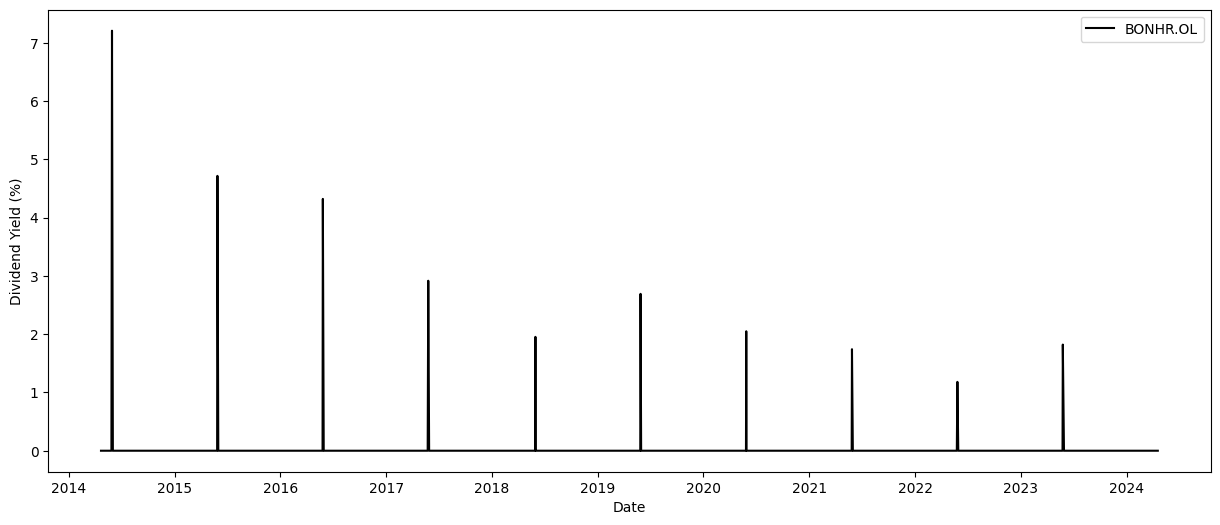

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.607811
share_price      1.000000
Name: share_price, dtype: float64


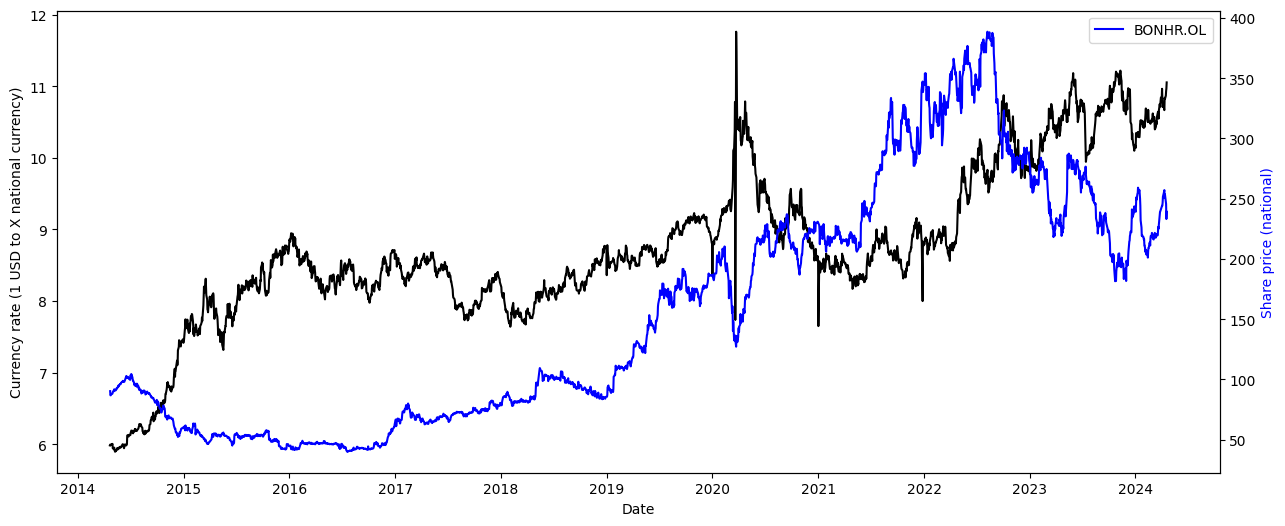

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

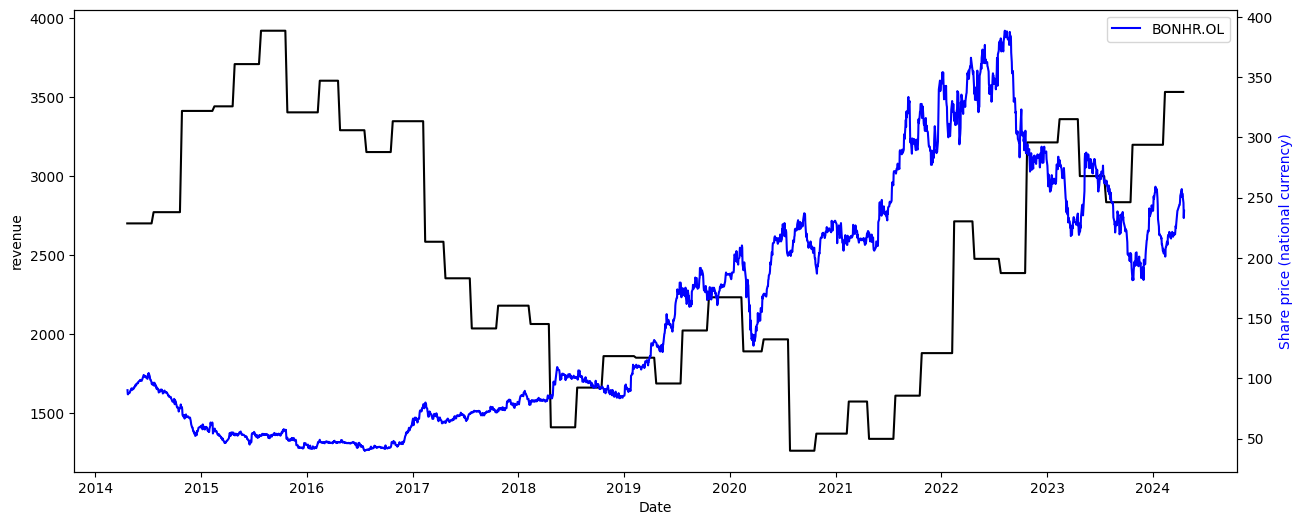

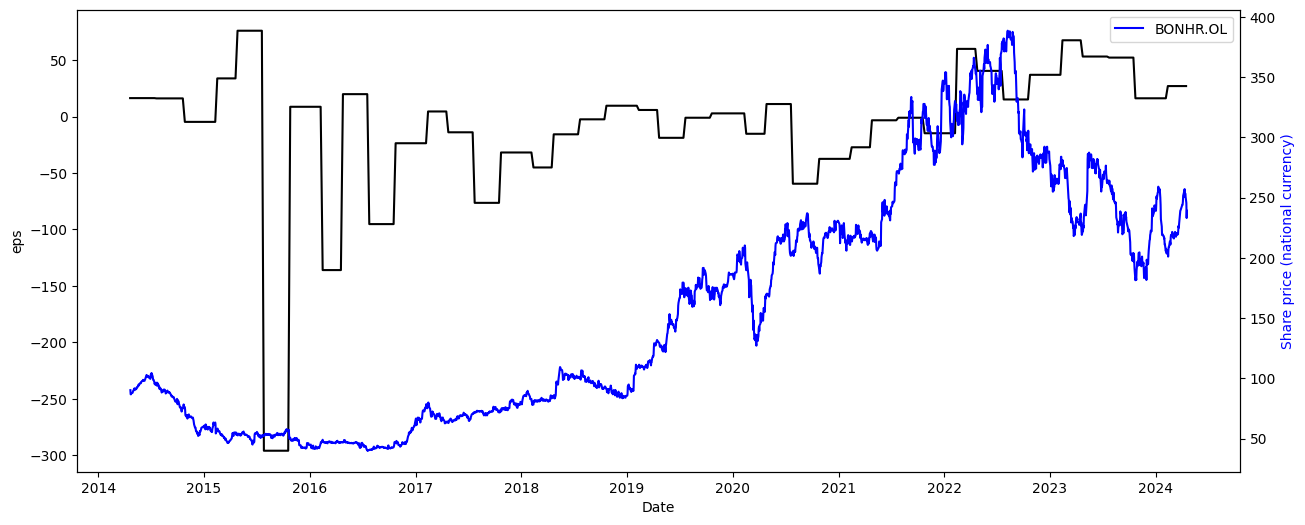

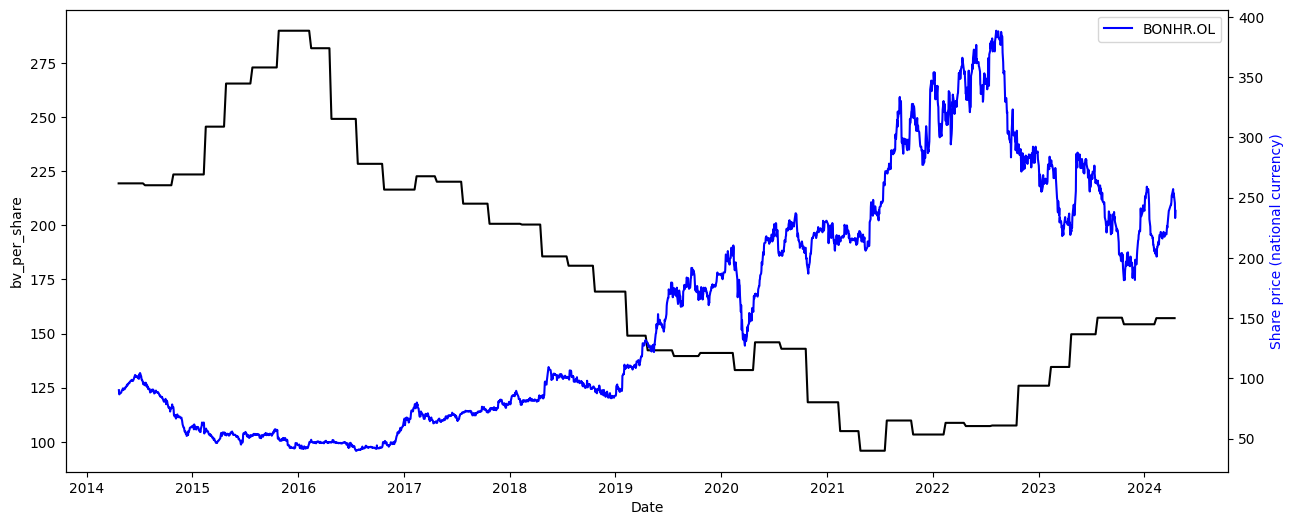

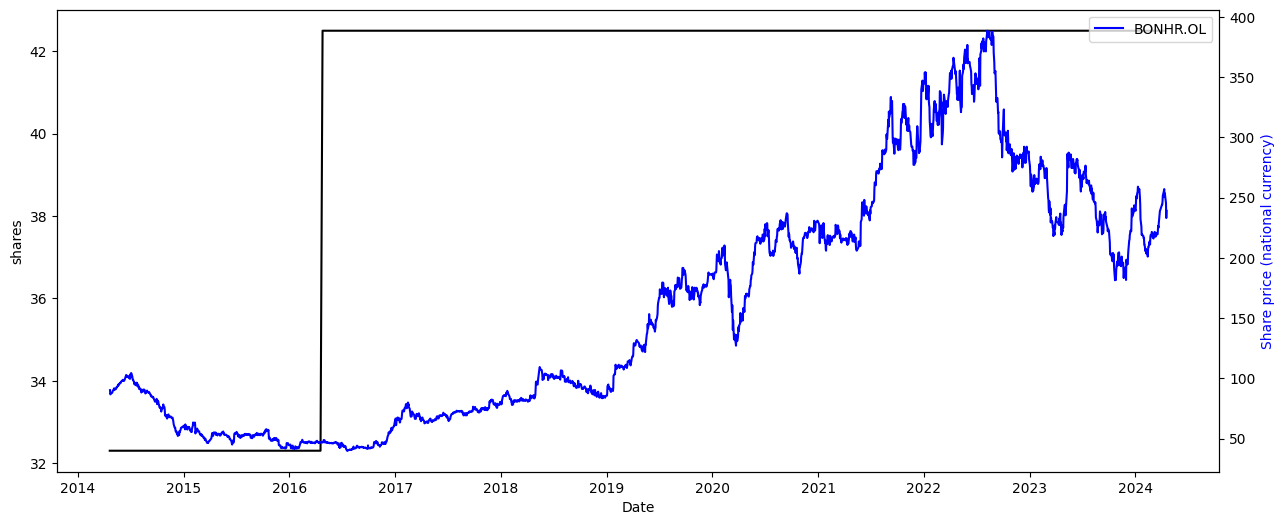

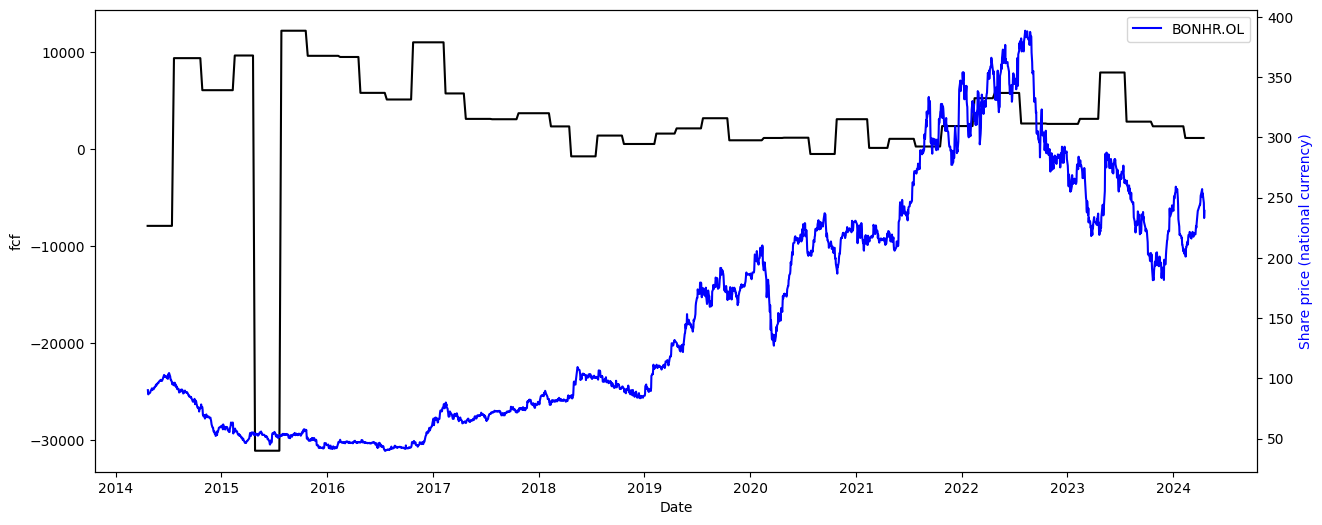

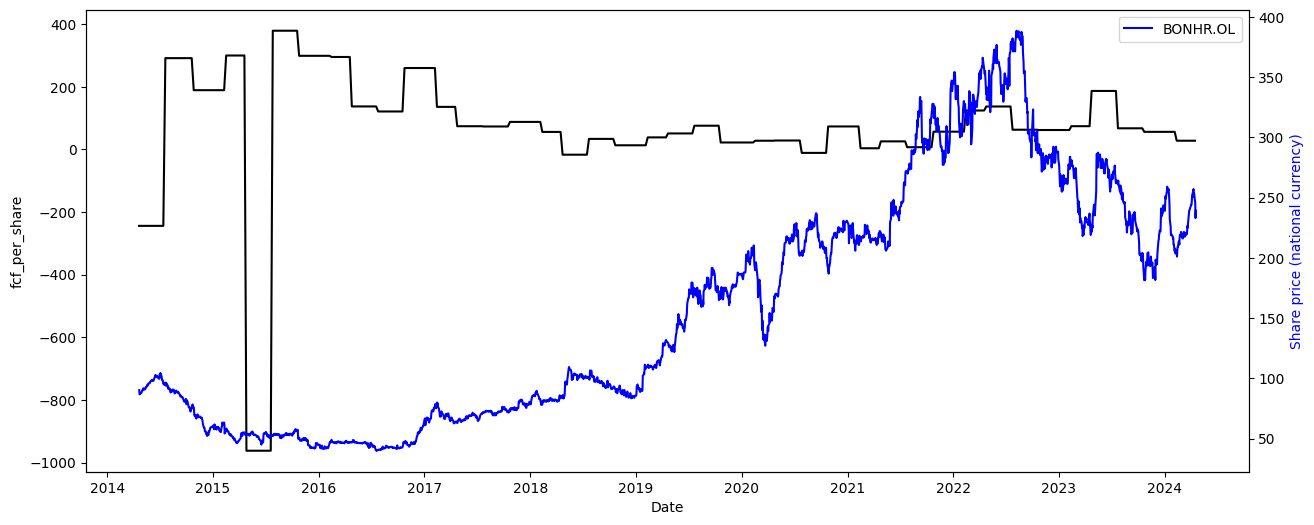

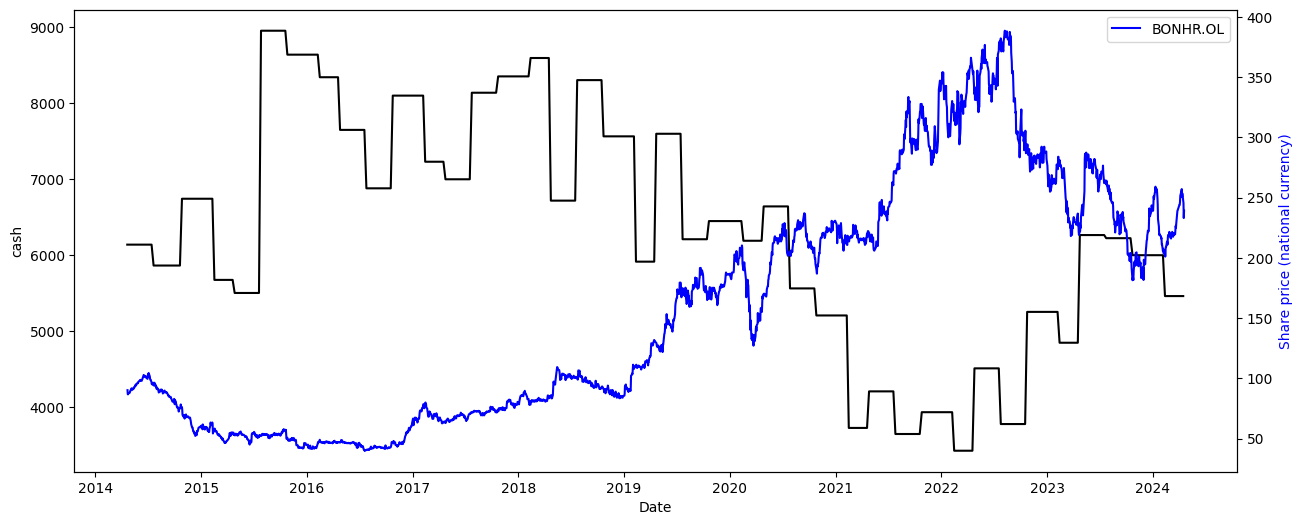

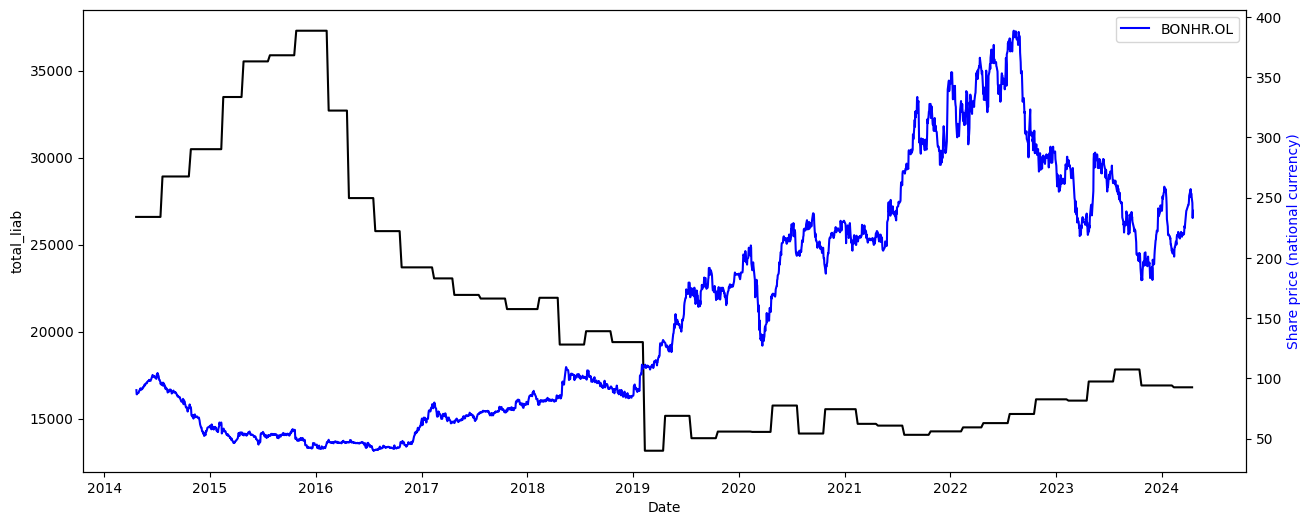

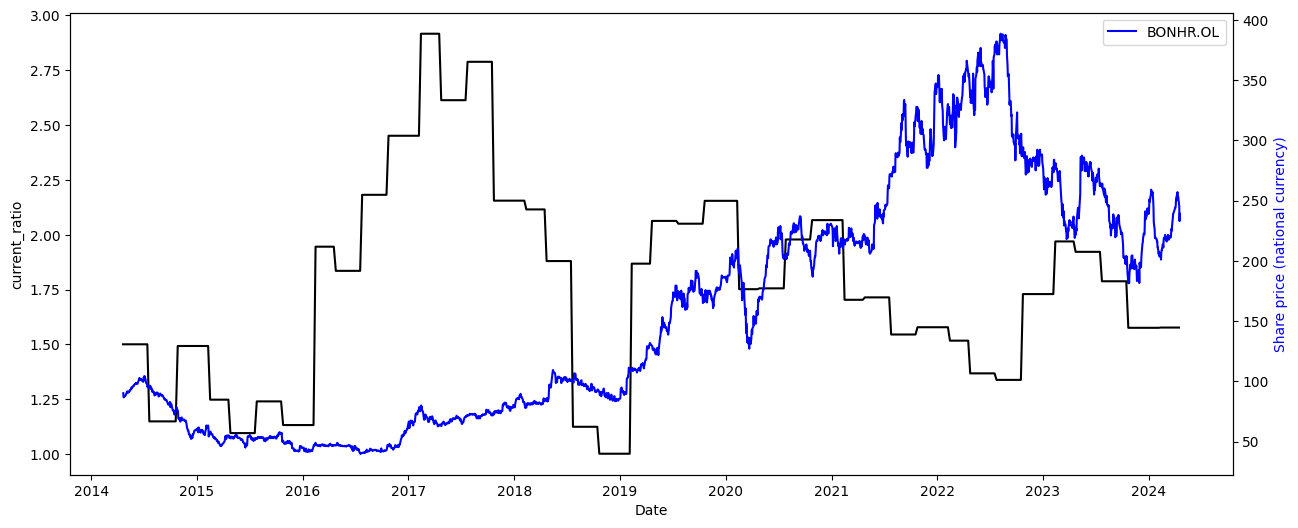

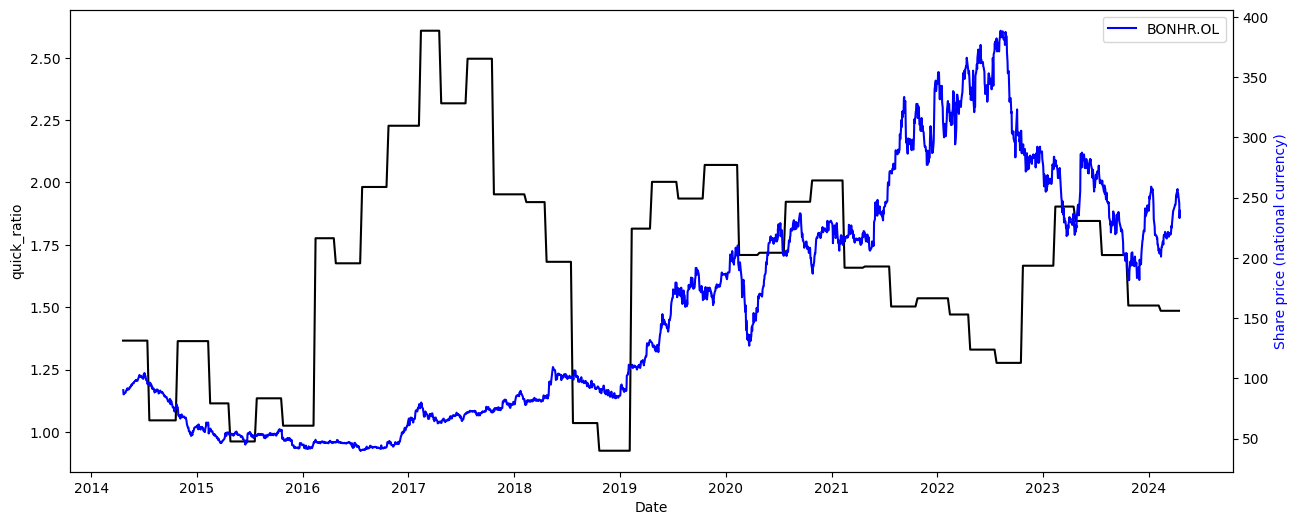

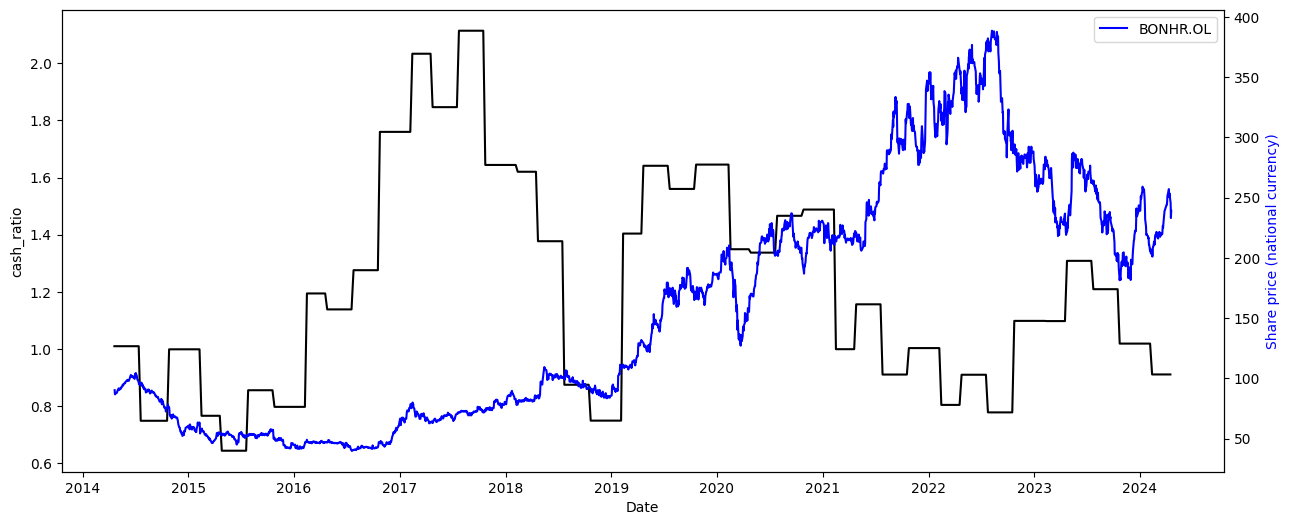

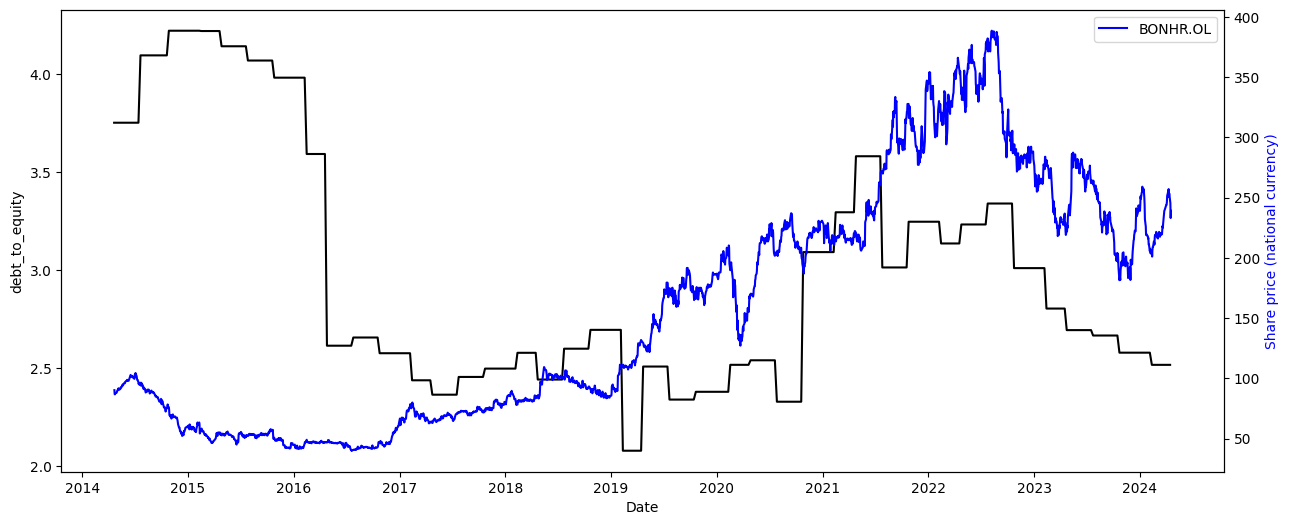

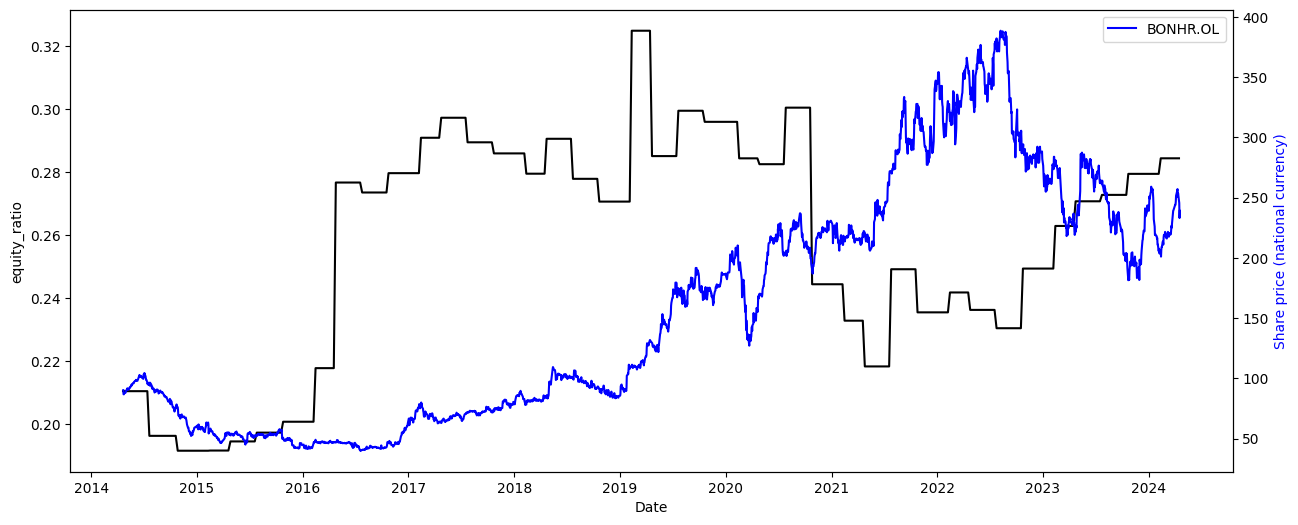

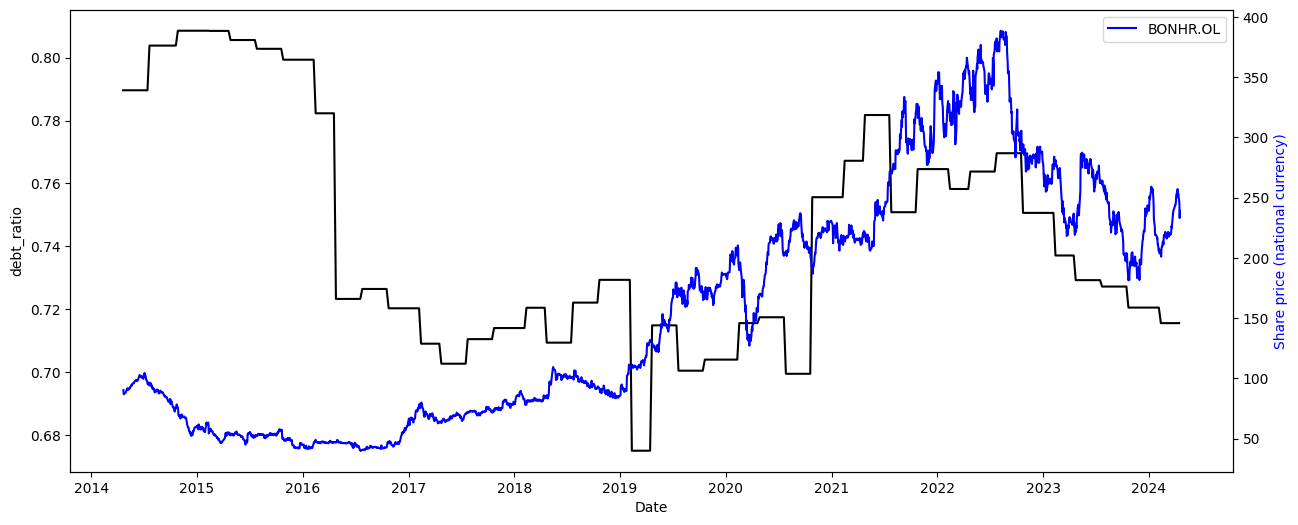

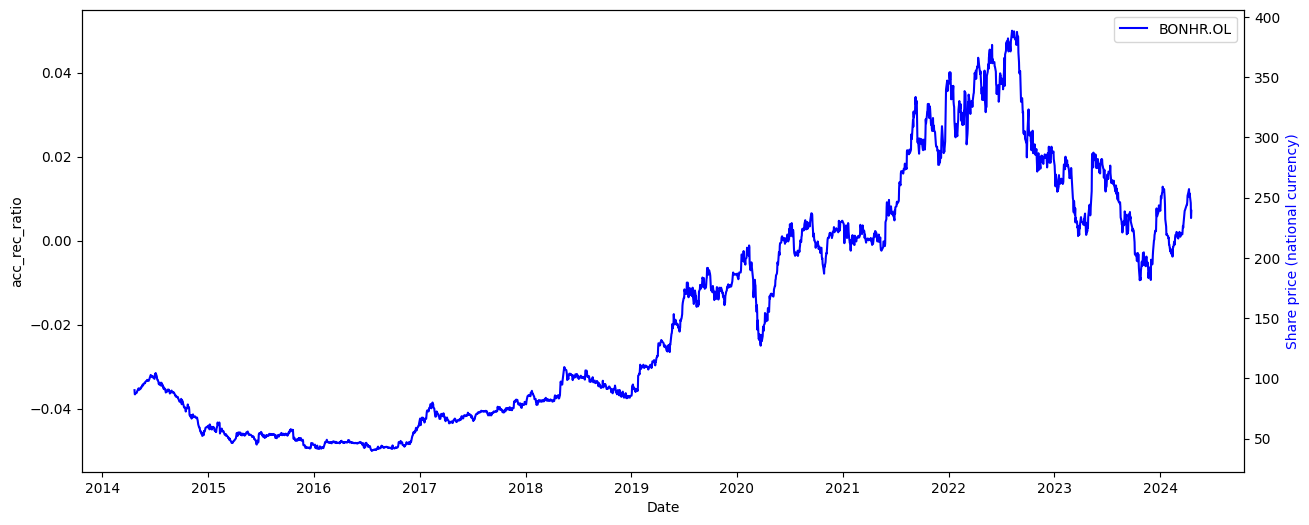

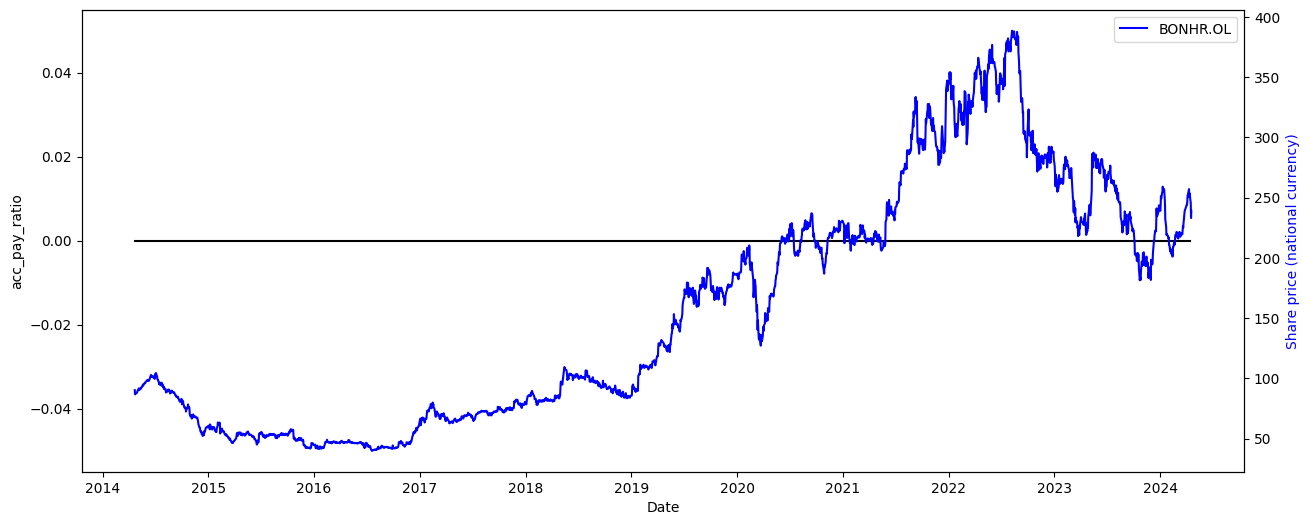

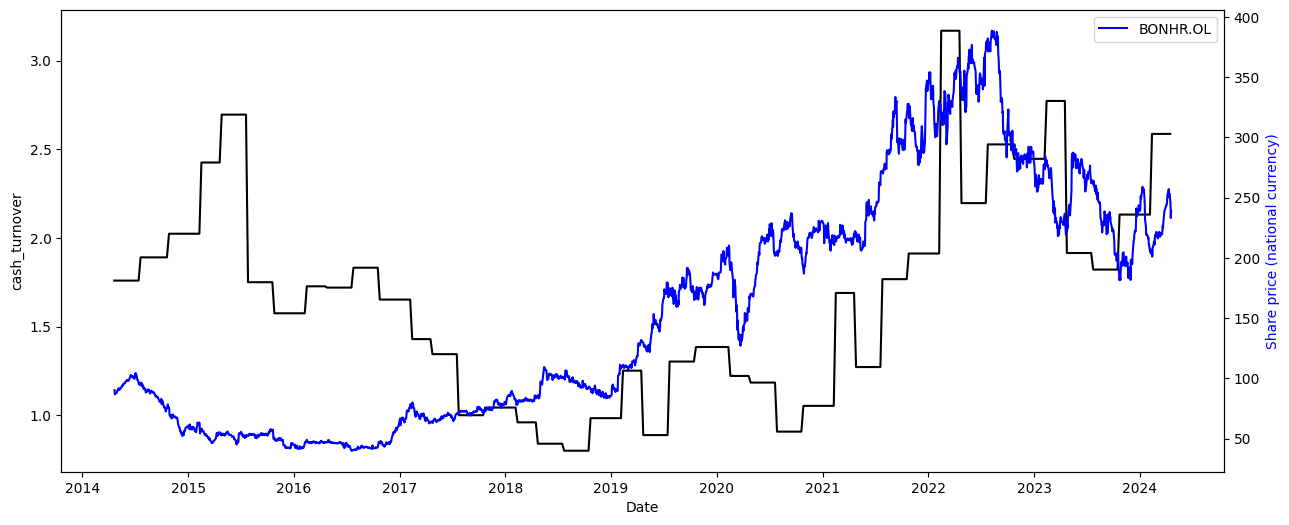

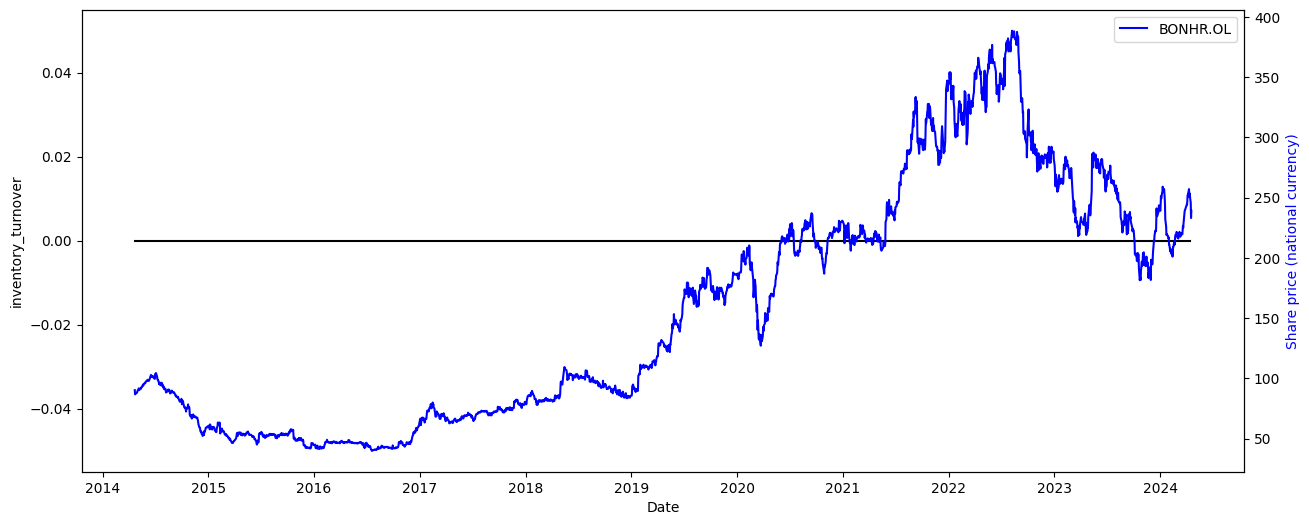

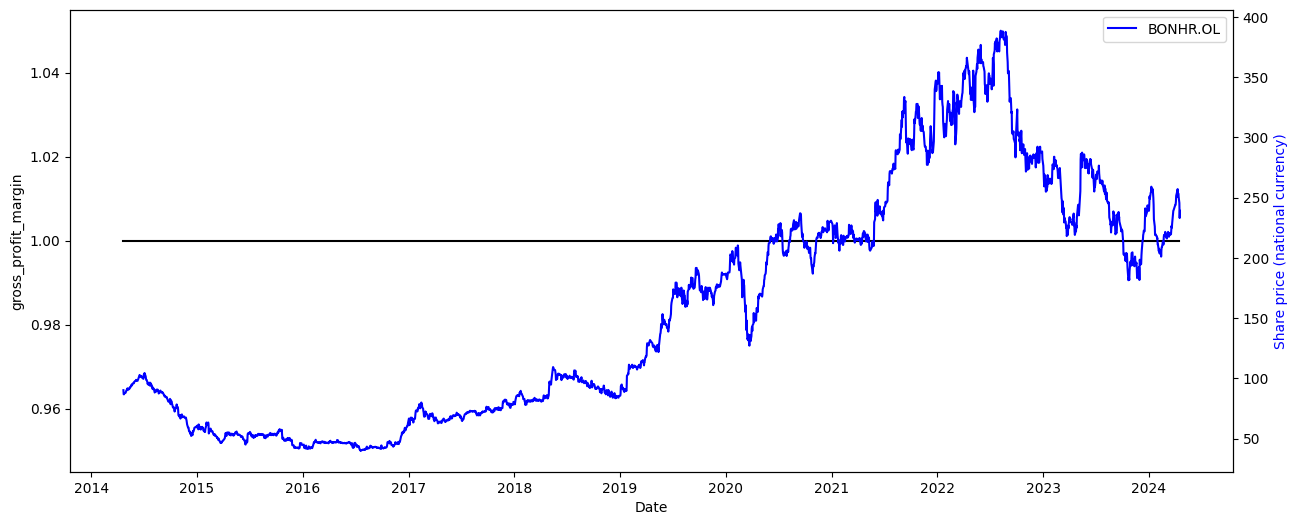

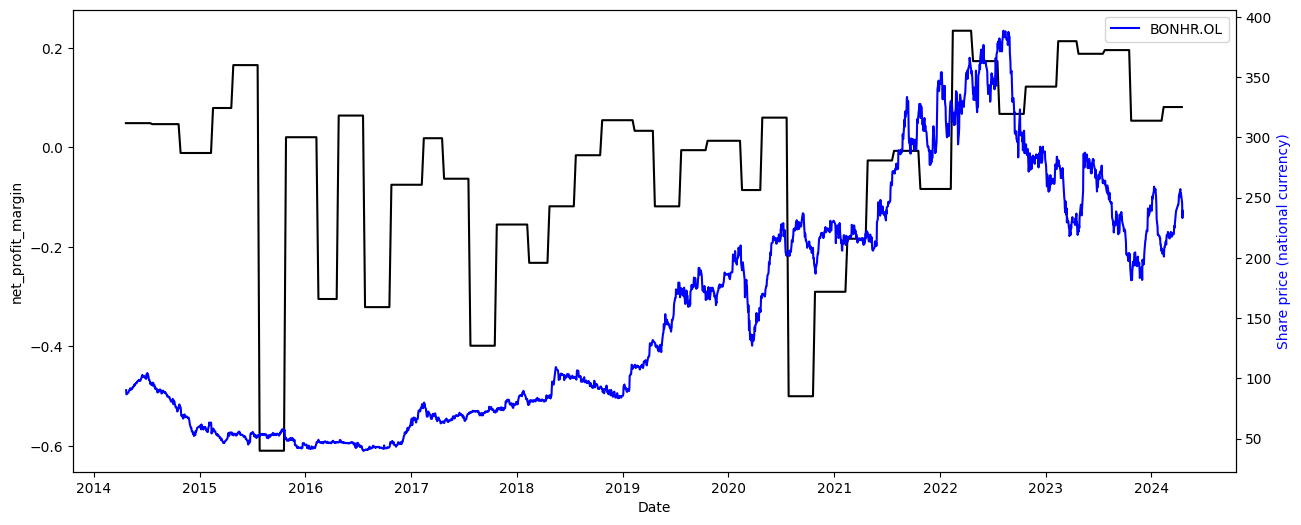

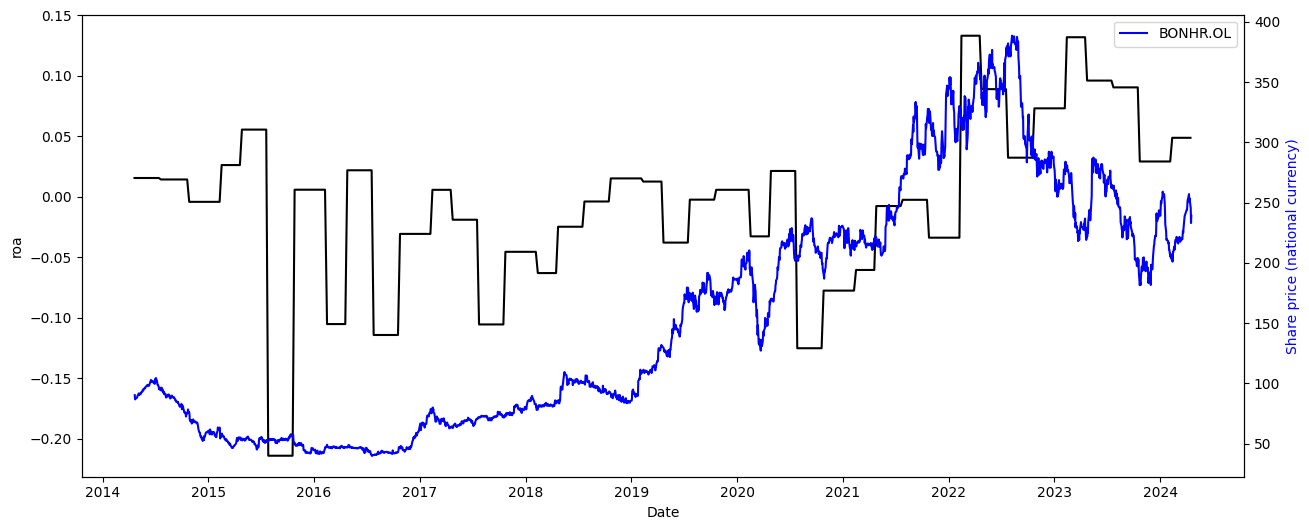

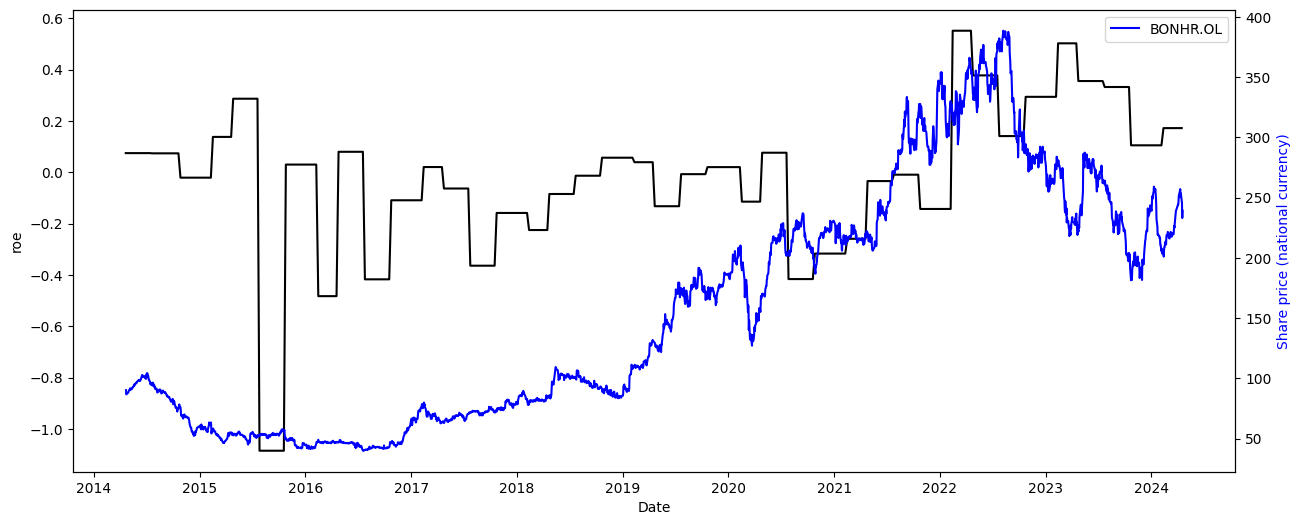

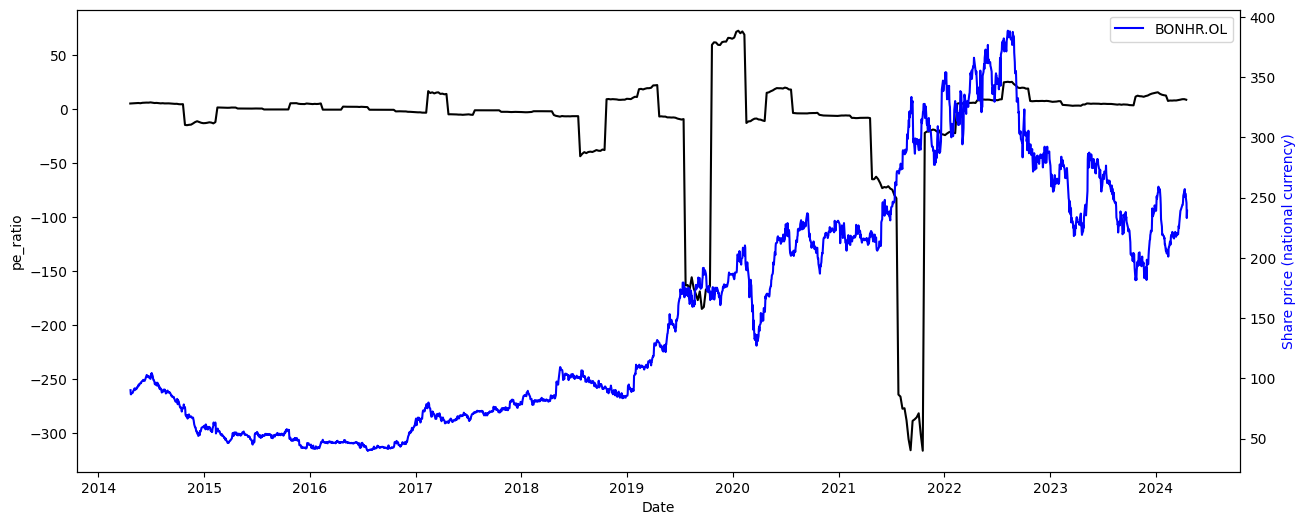

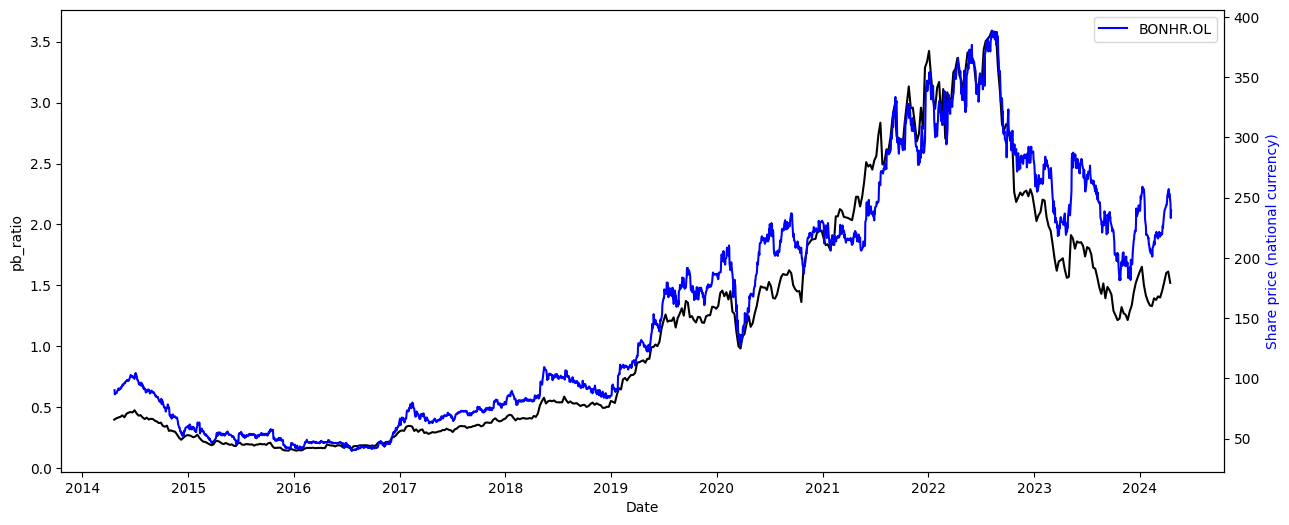

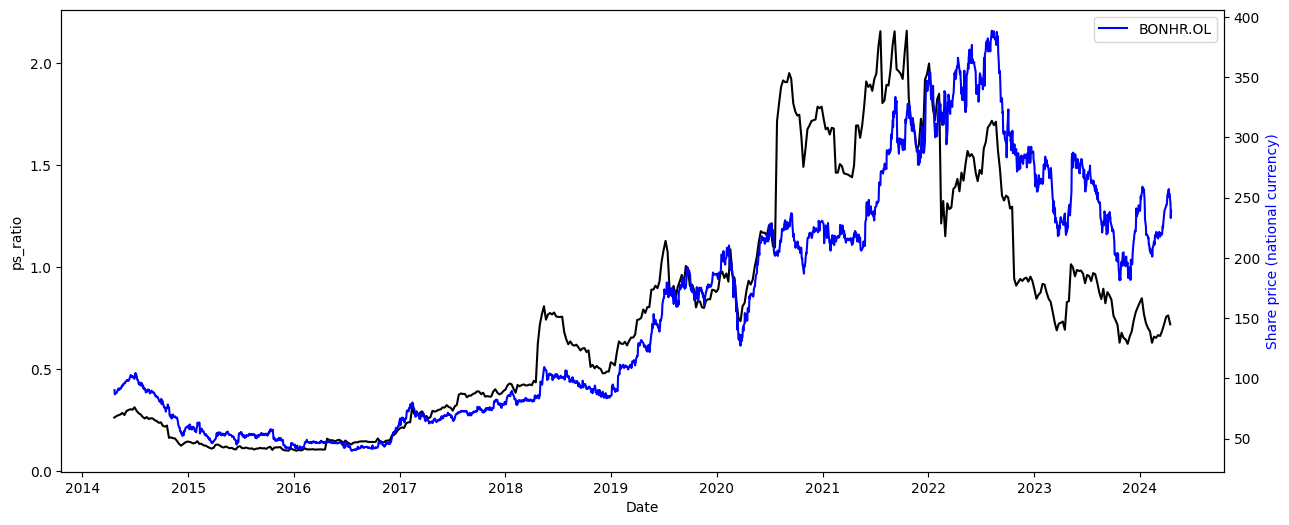

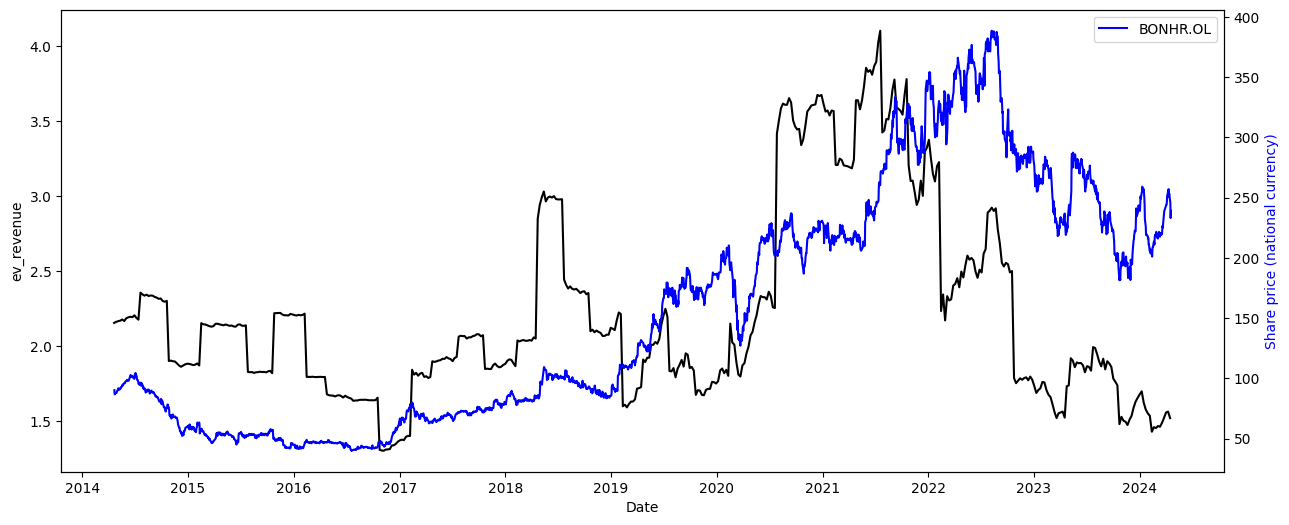

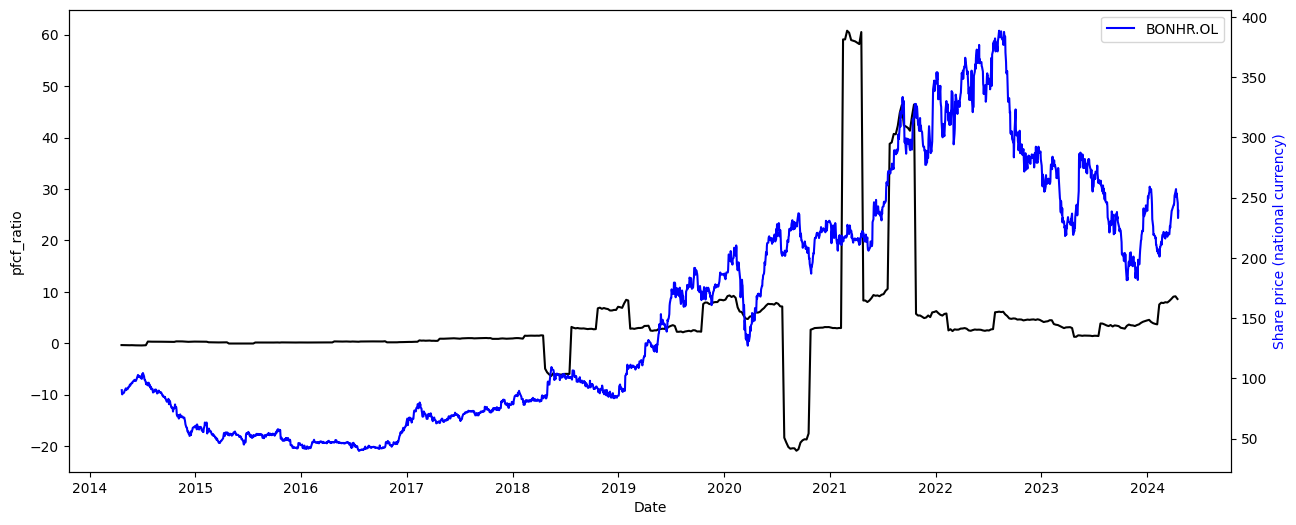

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

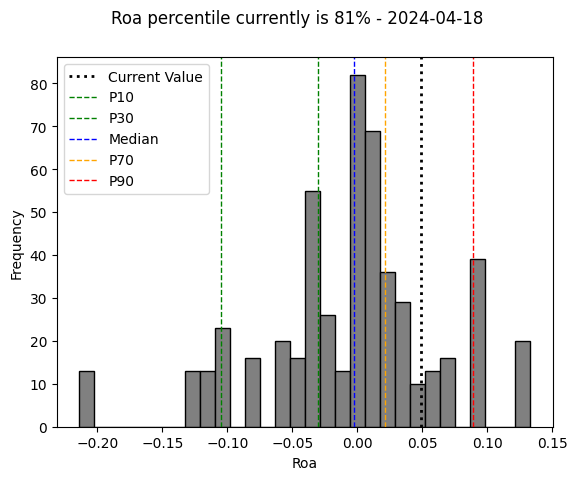

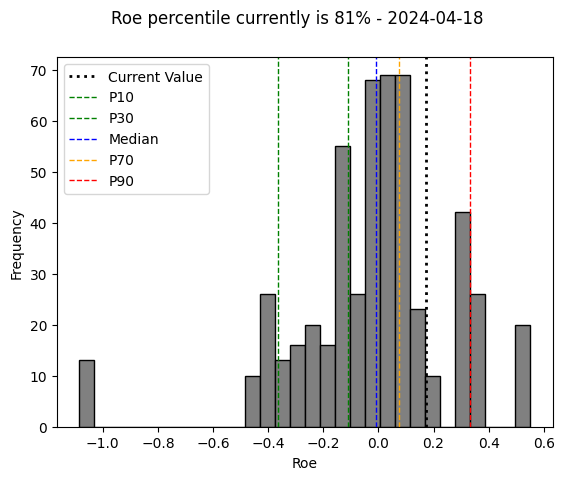

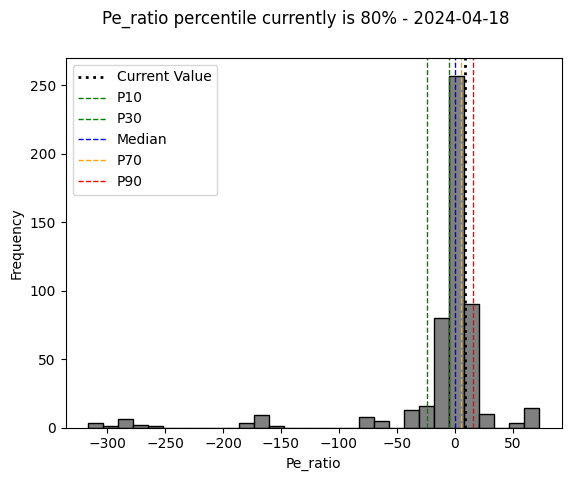

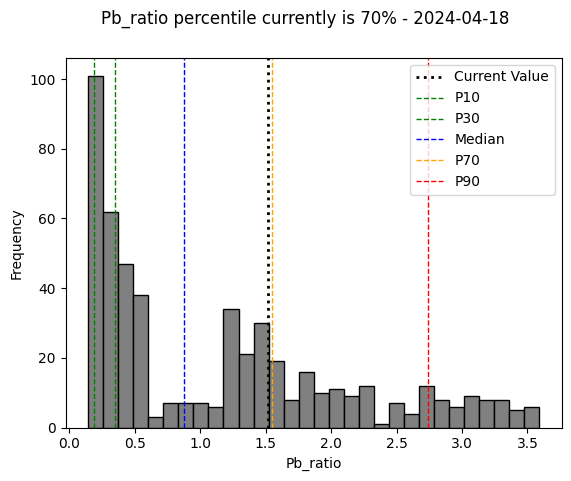

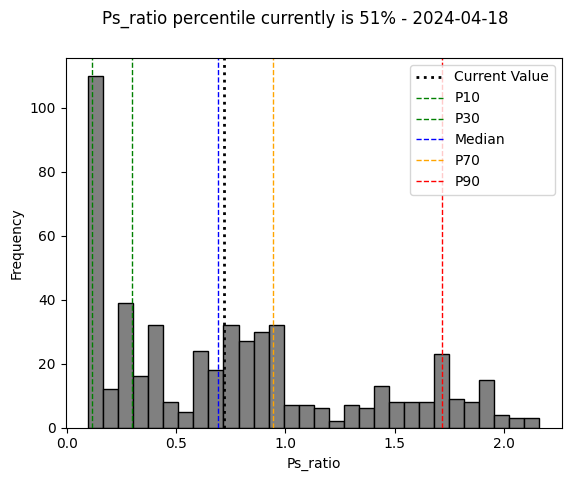

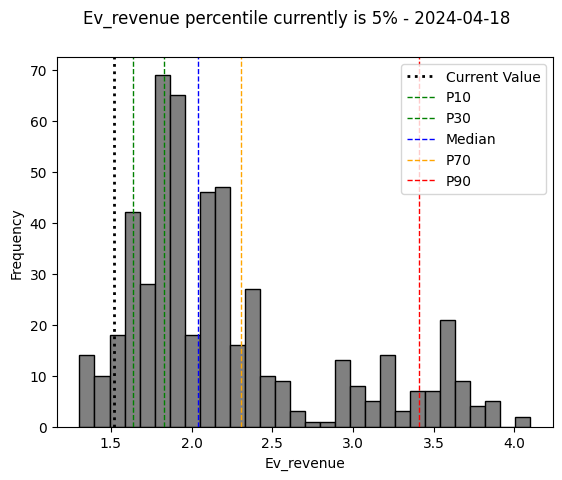

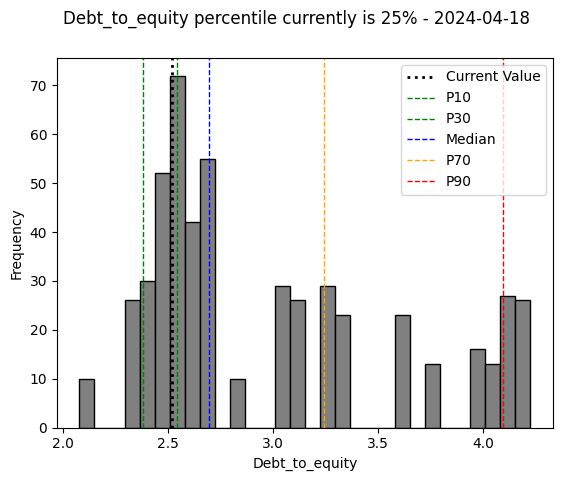

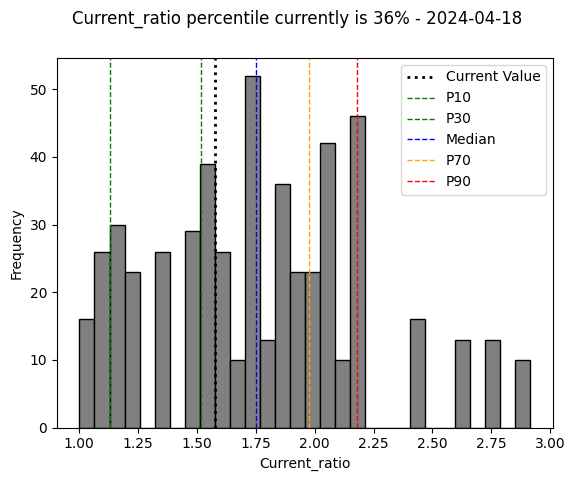

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.988361,0.063941,0.368496,0.102417,-0.187970,-0.001338,-0.259600
roe,0.988361,1.000000,0.059064,0.354771,0.115715,-0.151372,-0.036152,-0.216216
pe_ratio,0.063941,0.059064,1.000000,-0.232161,-0.354771,-0.394823,-0.003651,0.050150
pb_ratio,0.368496,0.354771,-0.232161,1.000000,0.890527,0.524518,-0.051288,-0.144631
ps_ratio,0.102417,0.115715,-0.354771,0.890527,1.000000,0.765190,-0.176860,-0.035991
ev_revenue,-0.187970,-0.151372,-0.394823,0.524518,0.765190,1.000000,0.193653,-0.189287
debt_to_equity,-0.001338,-0.036152,-0.003651,-0.051288,-0.176860,0.193653,1.000000,-0.624447
current_ratio,-0.259600,-0.216216,0.050150,-0.144631,-0.035991,-0.189287,-0.624447,1.000000


10 timestemos have been found!


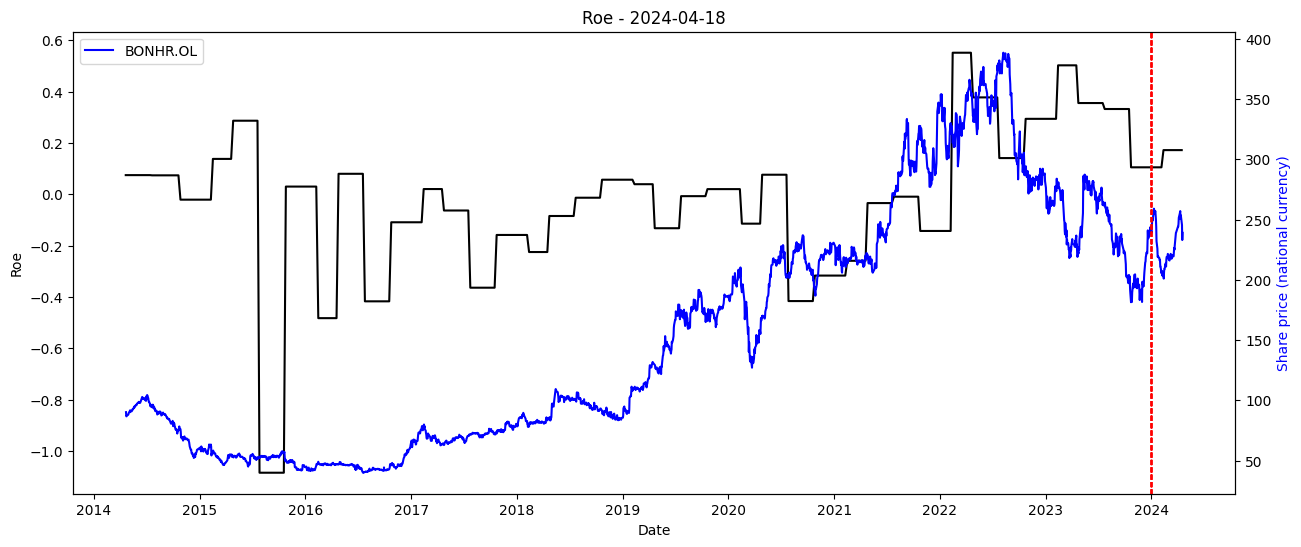

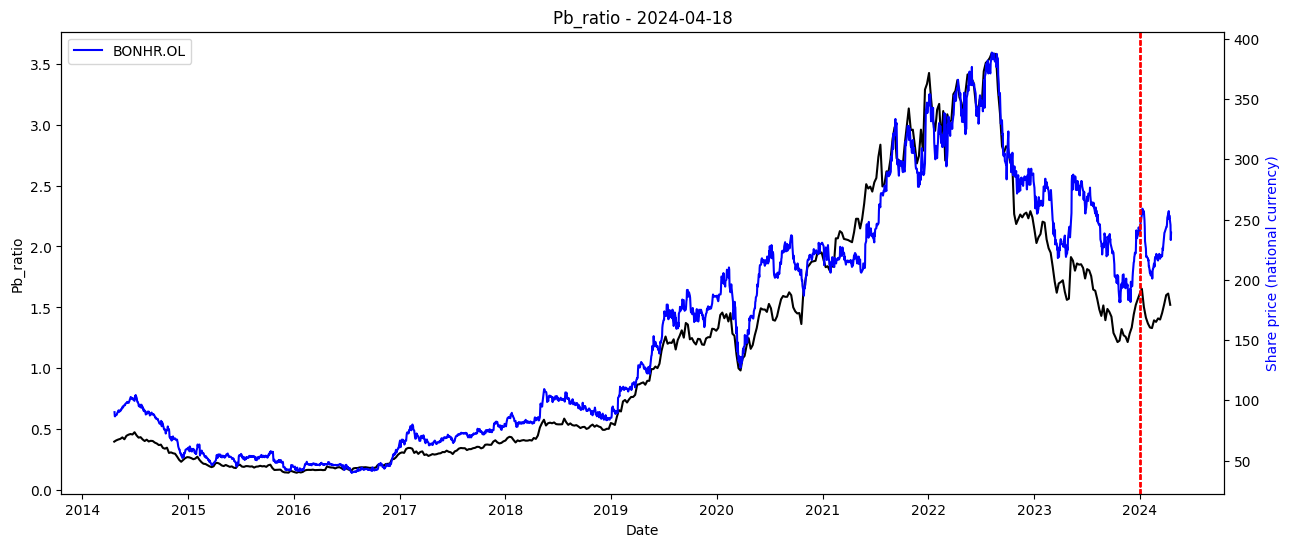

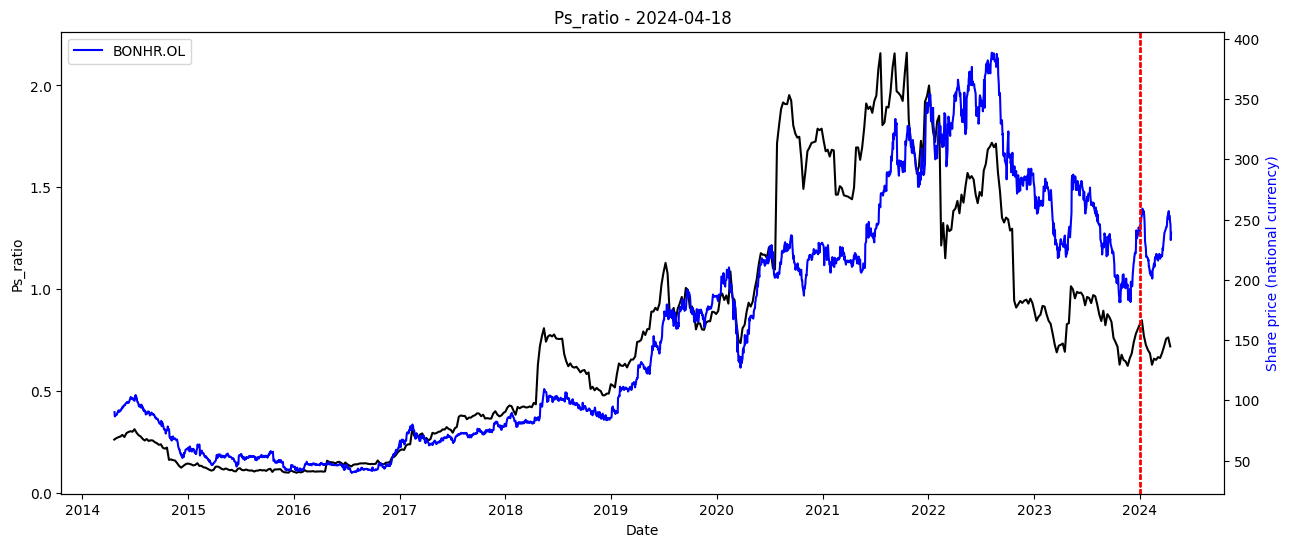

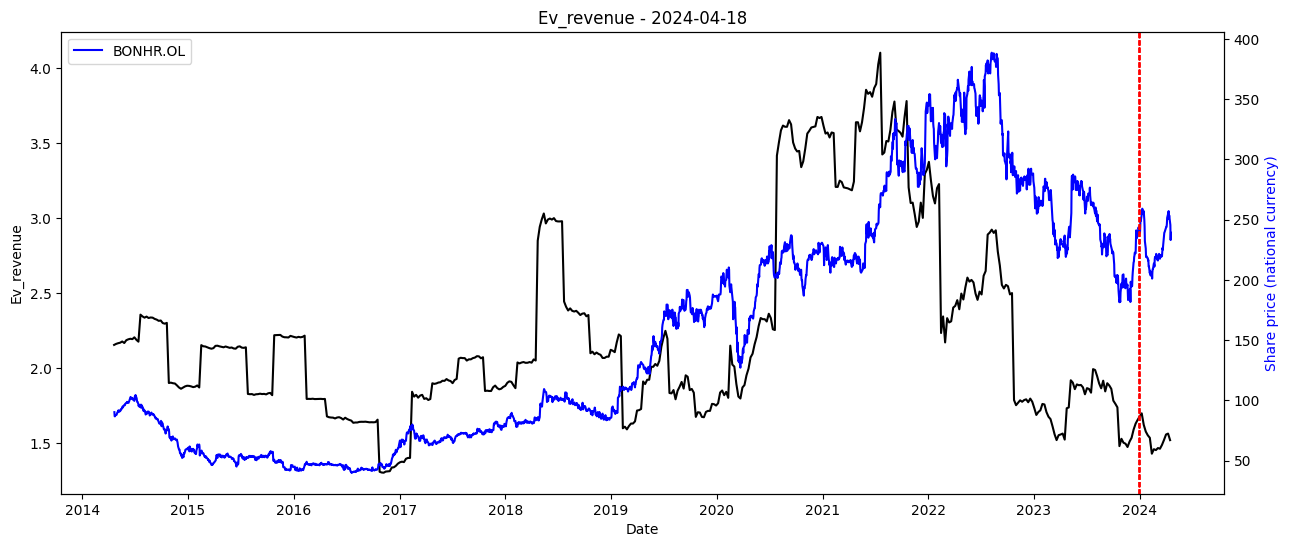

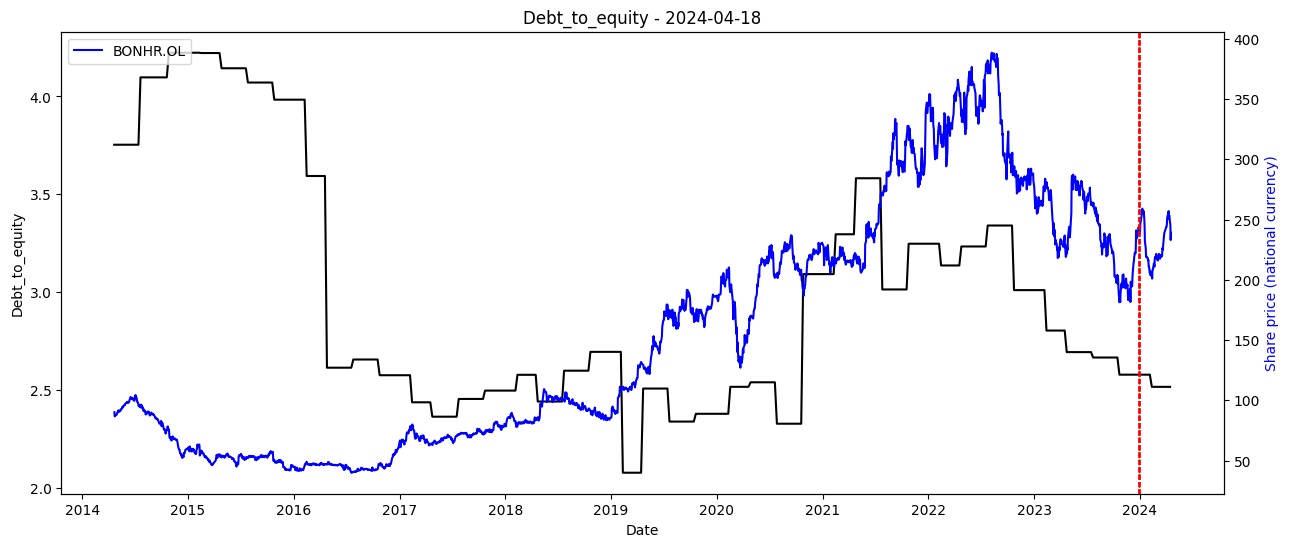

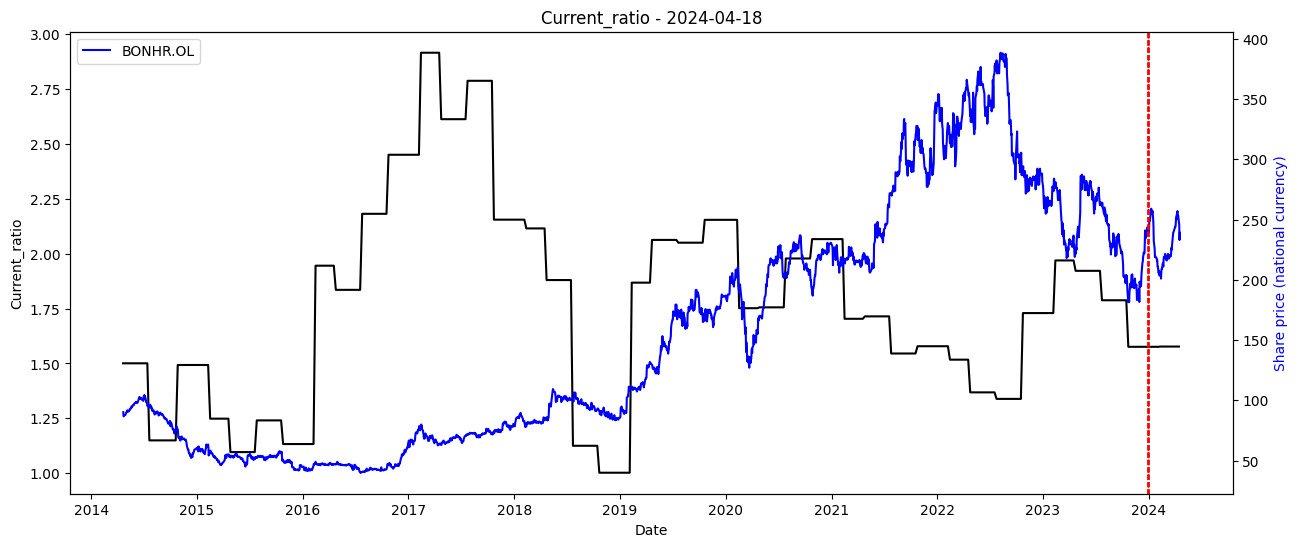

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )